In [ ]:
#The following represents code for face recognition. This has been done as a personal practise

In [3]:
#Importing required libraries

import os
from os import path
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
#%pip install mtcnn
#from mtcnn.mtcnn import MTCNN
# CNN
#import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
import dlib
import math

In [220]:
#Creating dataframe with individual details and saving to csv
celeb_name = os.listdir("C:/Users/paris/Desktop/Amrit Project/")
print(celeb_name)
count=[]
n=0
for name in celeb_name:
    #print(name)
    count1 = len(os.listdir("C:/Users/paris/Desktop/Amrit Project/"+name+"/"))
    count.append(count1)
    
df1 = pd.DataFrame({"Name":celeb_name,"Count":count})

#df1.to_csv("projectData/P3_Face_verification/pb_testing/allnames.csv")

#Creating dataframe for visuals of the images provided
width = []
height = []

for name in celeb_name:
    image_paths = os.listdir("C:/Users/paris/Desktop/Amrit Project/"+name+"/")
    for image_path in image_paths:
        img = "C:/Users/paris/Desktop/Amrit Project/"+name+"/"+ image_path
        dim = Image.open(img)
        width.append(dim.width)
        height.append(dim.height)
df2 = pd.DataFrame({"height":height,"width":width})
    

['Aaron_Peirsol', 'Aaron_Sorkin', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdullah', 'Abdullah_al-Attiyah', 'Abdullah_Gul', 'Abdullatif_Sener', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adrian_McPherson', 'Adrian_Nastase', 'Adrien_Brody', 'Ahmad_Masood', 'Ahmed_Chalabi', 'Ahmet_Necdet_Sezer', 'Aicha_El_Ouafi', 'Aitor_Gonzalez', 'Ai_Sugiyama', 'Akbar_Hashemi_Rafsanjani', 'Akhmed_Zakayev', 'Alan_Ball', 'Alan_Greenspan', 'Alan_Mulally', 'Alastair_Campbell', 'Alberto_Fujimori', 'Alberto_Ruiz_Gallardon', 'Albert_Costa', 'Albrecht_Mentz', 'Aldo_Paredes', 'Alec_Baldwin', 'Alejandro_Atchugarry', 'Alejandro_Avila', 'Alejandro_Toledo', 'Aleksander_Kwasniewski', 'Alexander_Downer', 'Alexander_Losyukov', 'Alexander_Rumyantsev', 'Alexandra_Stevenson', 'Alexandra_Vodjanikova', 'Alex_Barros', 'Alex_Penelas', 'Alex_Sink', 'Alice_Fisher', 'Alicia_Silverstone', 'Alimzhan_Tokhtakhounov', 'Alison_Lohm

In [217]:
print(celeb_name)

['Aaron_Peirsol', 'Aaron_Sorkin', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdullah', 'Abdullah_al-Attiyah', 'Abdullah_Gul', 'Abdullatif_Sener', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adrian_McPherson', 'Adrian_Nastase', 'Adrien_Brody', 'Ahmad_Masood', 'Ahmed_Chalabi', 'Ahmet_Necdet_Sezer', 'Aicha_El_Ouafi', 'Aitor_Gonzalez', 'Ai_Sugiyama', 'Akbar_Hashemi_Rafsanjani', 'Akhmed_Zakayev', 'Alan_Ball', 'Alan_Greenspan', 'Alan_Mulally', 'Alastair_Campbell', 'Alberto_Fujimori', 'Alberto_Ruiz_Gallardon', 'Albert_Costa', 'Albrecht_Mentz', 'Aldo_Paredes', 'Alec_Baldwin', 'Alejandro_Atchugarry', 'Alejandro_Avila', 'Alejandro_Toledo', 'Aleksander_Kwasniewski', 'Alexander_Downer', 'Alexander_Losyukov', 'Alexander_Rumyantsev', 'Alexandra_Stevenson', 'Alexandra_Vodjanikova', 'Alex_Barros', 'Alex_Penelas', 'Alex_Sink', 'Alice_Fisher', 'Alicia_Silverstone', 'Alimzhan_Tokhtakhounov', 'Alison_Lohm

In [222]:
#1: Checking the people for which dataset is provided and number of image available for each

#Number of unique data available: Count of rows of the df
df1_dedup=df1.drop_duplicates(keep='first')
unique_celeb = df1.shape[0]
print("Count :", unique_celeb)

#Check to see any folder with 0 image
zero_img = df1_dedup['Count']==0
zero_count = len(df1[zero_img])
print(zero_count)

#Total images available
tot_img = df1_dedup["Count"].sum()

#Check to see how many person has just one sample image for training
single_img = df1_dedup['Count']==1
single_count = len(df1[single_img])


Count : 1680
0


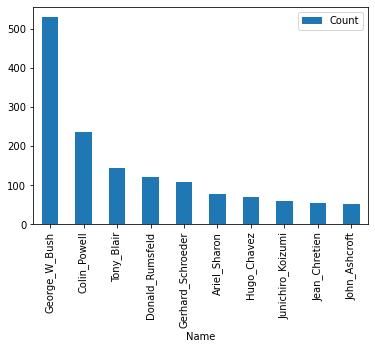

In [223]:
#Bar plot to check the frequency of training data provided

df_top10 = df1_dedup.sort_values(by="Count", ascending=False).head(10)
#df_top10
df_top10.plot.bar(x="Name", y="Count")


In [224]:
#Checking the image formats
df2.describe()

,height,width
count,9164.0,9164.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


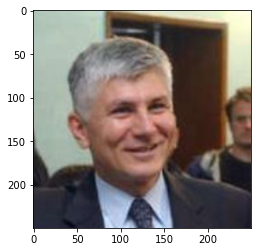

In [225]:
#Visualization of a sample picture
img
im = Image.open(img)
plt.imshow(im)

In [15]:
#gender and age detection

def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn=frame.copy()
    frameHeight=frameOpencvDnn.shape[0]
    frameWidth=frameOpencvDnn.shape[1]
    blob=cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections=net.forward()
    faceBoxes=[]
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:
            x1=int(detections[0,0,i,3]*frameWidth)
            y1=int(detections[0,0,i,4]*frameHeight)
            x2=int(detections[0,0,i,5]*frameWidth)
            y2=int(detections[0,0,i,6]*frameHeight)
            faceBoxes.append([x1,y1,x2,y2])
            cv2.rectangle(frameOpencvDnn, (x1,y1), (x2,y2), (0,255,0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn,faceBoxes


#reading the image
#frame = cv2.imread("girl2.JPG")
padding=20

#Using the protocol files with trained weights for both age and gender
faceProto="opencv_face_detector.pbtxt"
faceModel="opencv_face_detector_uint8.pb"
ageProto="age_deploy.prototxt"
ageModel="age_net.caffemodel"
genderProto="gender_deploy.prototxt"
genderModel="gender_net.caffemodel"

#Specifying age groups and gender list
MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
ageList=['(0-20)', '(21-30)', '(31-40)', '(41-50)','(51-60)','(61-70)','(71-80)', '(81-100)']
genderList=['Male','Female']

#Reading the models as stored above
faceNet=cv2.dnn.readNet(faceModel,faceProto)
ageNet=cv2.dnn.readNet(ageModel,ageProto)
genderNet=cv2.dnn.readNet(genderModel,genderProto)

#Defining empty list to read the values so as to accumulate them later as a single dataframe
celebrity = []
gender1 = []
age1= []

#reading the image and calculating gender and age of each image
images=os.listdir("C:/Users/paris/Desktop/Amrit Project/")
for image in images:
    image_paths = os.listdir("C:/Users/paris/Desktop/Amrit Project/"+image+"/") 
    for image_path in image_paths:
        frame = cv2.imread("C:/Users/paris/Desktop/Amrit Project/"+image+"/"+image_path)
        print(image_path)
        resultImg,faceBoxes=highlightFace(faceNet,frame)
        if not faceBoxes:
            print("No face detected")
        else:
            for faceBox in faceBoxes:
                face=frame[max(0,faceBox[1]-padding):
                            min(faceBox[3]+padding,frame.shape[0]-1),max(0,faceBox[0]-padding)
                            :min(faceBox[2]+padding, frame.shape[1]-1)]

            blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
            genderNet.setInput(blob)
            genderPreds=genderNet.forward()
            gender=genderList[genderPreds[0].argmax()]
            #print(genderPreds[0].argmax())

            ageNet.setInput(blob)
            agePreds=ageNet.forward()
            age=ageList[agePreds[0].argmax()]
            
            celebrity.append(image)
            gender1.append(gender)
            age1.append(age[1:-1])
    
            #print(f'Object: {image_path}')
            #print(f'Gender: {gender}')
            #print(f'Age: {age[1:-1]} years')

df_bio = pd.DataFrame({"Name":celebrity,"Gender":gender1, "Age group":age1})

#gender
df_bio_gender = df_bio.copy()
df_bio_gender=df_bio_gender.drop("Age group",1)
df_bio_gender["Count"]=df_bio_gender.groupby(["Name","Gender"])["Gender"].transform('count')
df_bio_gender=df_bio_gender.iloc[df_bio_gender.groupby(["Name"])["Count"].idxmax()]
#df_bio_gender

#age
df_bio_age = df_bio.copy()
df_bio_age=df_bio_age.drop("Gender",1)
df_bio_age["Count"]=df_bio_age.groupby(["Name","Age group"])["Age group"].transform('count')
df_bio_age=df_bio_age.iloc[df_bio_age.groupby(["Name"])["Count"].idxmax()]
#df_bio_age

Aaron_Peirsol_0001.jpg
Aaron_Peirsol_0002.jpg
Aaron_Peirsol_0003.jpg
Aaron_Peirsol_0004.jpg
Aaron_Sorkin_0001.jpg
Aaron_Sorkin_0002.jpg
Abdel_Nasser_Assidi_0001.jpg
Abdel_Nasser_Assidi_0002.jpg
Abdoulaye_Wade_0001.jpg
Abdoulaye_Wade_0002.jpg
Abdoulaye_Wade_0003.jpg
Abdoulaye_Wade_0004.jpg
Abdullah_0001.jpg
Abdullah_0002.jpg
Abdullah_0003.jpg
Abdullah_0004.jpg
Abdullah_al-Attiyah_0001.jpg
Abdullah_al-Attiyah_0002.jpg
Abdullah_al-Attiyah_0003.jpg
Abdullah_Gul_0001.jpg
Abdullah_Gul_0002.jpg
Abdullah_Gul_0003.jpg
Abdullah_Gul_0004.jpg
Abdullah_Gul_0005.jpg
Abdullah_Gul_0006.jpg
Abdullah_Gul_0007.jpg
Abdullah_Gul_0008.jpg
Abdullah_Gul_0009.jpg
Abdullah_Gul_0010.jpg
Abdullah_Gul_0011.jpg
Abdullah_Gul_0012.jpg
Abdullah_Gul_0013.jpg
Abdullah_Gul_0014.jpg
Abdullah_Gul_0015.jpg
Abdullah_Gul_0016.jpg
Abdullah_Gul_0017.jpg
Abdullah_Gul_0018.jpg
Abdullah_Gul_0019.jpg
Abdullatif_Sener_0001.jpg
Abdullatif_Sener_0002.jpg
Abel_Pacheco_0001.jpg
Abel_Pacheco_0002.jpg
Abel_Pacheco_0003.jpg
Abel_Pacheco_00

Ana_Guevara_0001.jpg
Ana_Guevara_0002.jpg
Ana_Guevara_0003.jpg
Ana_Guevara_0004.jpg
Ana_Guevara_0005.jpg
Ana_Guevara_0006.jpg
Ana_Guevara_0007.jpg
Ana_Palacio_0001.jpg
Ana_Palacio_0002.jpg
Ana_Palacio_0003.jpg
Ana_Palacio_0004.jpg
Ana_Palacio_0005.jpg
Ana_Palacio_0006.jpg
Ana_Palacio_0007.jpg
Ana_Palacio_0008.jpg
Anders_Ebbeson_0001.jpg
Anders_Ebbeson_0002.jpg
Anders_Ebbeson_0003.jpg
Anders_Fogh_Rasmussen_0001.jpg
Anders_Fogh_Rasmussen_0002.jpg
Anders_Fogh_Rasmussen_0003.jpg
Anders_Fogh_Rasmussen_0004.jpg
Andrei_Mikhnevich_0001.jpg
Andrei_Mikhnevich_0002.jpg
Andrew_Bunner_0001.jpg
Andrew_Bunner_0002.jpg
Andrew_Cuomo_0001.jpg
Andrew_Cuomo_0002.jpg
Andrew_Niccol_0001.jpg
Andrew_Niccol_0002.jpg
Andrew_Weissmann_0001.jpg
Andrew_Weissmann_0002.jpg
Andrew_Weissmann_0003.jpg
Andre_Agassi_0001.jpg
Andre_Agassi_0002.jpg
Andre_Agassi_0003.jpg
Andre_Agassi_0004.jpg
Andre_Agassi_0005.jpg
Andre_Agassi_0006.jpg
Andre_Agassi_0007.jpg
Andre_Agassi_0008.jpg
Andre_Agassi_0009.jpg
Andre_Agassi_0010.jpg
A

Arnold_Schwarzenegger_0038.jpg
Arnold_Schwarzenegger_0039.jpg
Arnold_Schwarzenegger_0040.jpg
Arnold_Schwarzenegger_0041.jpg
Arnold_Schwarzenegger_0042.jpg
Aron_Ralston_0001.jpg
Aron_Ralston_0002.jpg
Arsinee_Khanjian_0001.jpg
Arsinee_Khanjian_0002.jpg
Arturo_Gatti_0001.jpg
Arturo_Gatti_0002.jpg
Arturo_Gatti_0003.jpg
Art_Hoffmann_0001.jpg
Art_Hoffmann_0002.jpg
Art_Howe_0001.jpg
Art_Howe_0002.jpg
Art_Howe_0003.jpg
Art_Howe_0004.jpg
Arye_Mekel_0001.jpg
Arye_Mekel_0002.jpg
Asa_Hutchinson_0001.jpg
Asa_Hutchinson_0002.jpg
Ashanti_0001.jpg
Ashanti_0002.jpg
Ashanti_0003.jpg
Ashanti_0004.jpg
Ashanti_0005.jpg
Ashton_Kutcher_0001.jpg
Ashton_Kutcher_0002.jpg
Ashton_Kutcher_0003.jpg
Atal_Bihari_Vajpayee_0001.jpg
Atal_Bihari_Vajpayee_0002.jpg
Atal_Bihari_Vajpayee_0003.jpg
Atal_Bihari_Vajpayee_0004.jpg
Atal_Bihari_Vajpayee_0005.jpg
Atal_Bihari_Vajpayee_0006.jpg
Atal_Bihari_Vajpayee_0007.jpg
Atal_Bihari_Vajpayee_0008.jpg
Atal_Bihari_Vajpayee_0009.jpg
Atal_Bihari_Vajpayee_0010.jpg
Atal_Bihari_Vajpayee_0

Brigitte_Boisselier_0002.jpg
Britney_Spears_0001.jpg
Britney_Spears_0002.jpg
Britney_Spears_0003.jpg
Britney_Spears_0004.jpg
Britney_Spears_0005.jpg
Britney_Spears_0006.jpg
Britney_Spears_0007.jpg
Britney_Spears_0008.jpg
Britney_Spears_0009.jpg
Britney_Spears_0010.jpg
Britney_Spears_0011.jpg
Britney_Spears_0012.jpg
Britney_Spears_0013.jpg
Britney_Spears_0014.jpg
Brooke_Shields_0001.jpg
Brooke_Shields_0002.jpg
Bruce_Springsteen_0001.jpg
Bruce_Springsteen_0002.jpg
Bruce_Springsteen_0003.jpg
Bruce_Springsteen_0004.jpg
Bruce_Van_De_Velde_0001.jpg
Bruce_Van_De_Velde_0002.jpg
Bruce_Weber_0001.jpg
Bruce_Weber_0002.jpg
Bud_Selig_0001.jpg
Bud_Selig_0002.jpg
Bud_Selig_0003.jpg
Bud_Selig_0004.jpg
Bulent_Ecevit_0001.jpg
Bulent_Ecevit_0002.jpg
Bulent_Ecevit_0003.jpg
Bulent_Ecevit_0004.jpg
Bulent_Ecevit_0005.jpg
Bulent_Ecevit_0006.jpg
Butch_Davis_0001.jpg
Butch_Davis_0002.jpg
Byron_Scott_0001.jpg
Byron_Scott_0002.jpg
Calista_Flockhart_0001.jpg
Calista_Flockhart_0002.jpg
Calista_Flockhart_0003.jpg
Ca

Chuck_Amato_0002.jpg
Chuck_Yeager_0001.jpg
Chuck_Yeager_0002.jpg
Chung_Mong-hun_0001.jpg
Chung_Mong-hun_0002.jpg
Chung_Mong-joon_0001.jpg
Chung_Mong-joon_0002.jpg
Cindy_Crawford_0001.jpg
Cindy_Crawford_0002.jpg
Cindy_Crawford_0003.jpg
Cindy_Margolis_0001.jpg
Cindy_Margolis_0002.jpg
Ciro_Gomes_0001.jpg
Ciro_Gomes_0002.jpg
Ciro_Gomes_0003.jpg
Ciro_Gomes_0004.jpg
Ciro_Gomes_0005.jpg
Claire_Danes_0001.jpg
Claire_Danes_0002.jpg
Claire_Danes_0003.jpg
Claire_Hentzen_0001.jpg
Claire_Hentzen_0002.jpg
Claire_Leger_0001.jpg
Claire_Leger_0002.jpg
Clara_Harris_0001.jpg
Clara_Harris_0002.jpg
Clara_Harris_0003.jpg
Clara_Harris_0004.jpg
Clara_Harris_0005.jpg
Clare_Short_0001.jpg
Clare_Short_0002.jpg
Clare_Short_0003.jpg
Clare_Short_0004.jpg
Claudia_Pechstein_0001.jpg
Claudia_Pechstein_0002.jpg
Claudia_Pechstein_0003.jpg
Claudia_Pechstein_0004.jpg
Claudia_Pechstein_0005.jpg
Claudia_Schiffer_0001.jpg
Claudia_Schiffer_0002.jpg
Claudia_Schiffer_0003.jpg
Clay_Aiken_0001.jpg
Clay_Aiken_0002.jpg
Clay_Aiken_0

Damon_van_Dam_0001.jpg
Damon_van_Dam_0002.jpg
Daniela_Hantuchova_0001.jpg
Daniela_Hantuchova_0002.jpg
Daniel_Day-Lewis_0001.jpg
Daniel_Day-Lewis_0002.jpg
Daniel_Day-Lewis_0003.jpg
Daniel_Radcliffe_0001.jpg
Daniel_Radcliffe_0002.jpg
Daniel_Radcliffe_0003.jpg
Daniel_Radcliffe_0004.jpg
Dan_Morales_0001.jpg
Dan_Morales_0002.jpg
Dan_Morales_0003.jpg
Dan_Wheldon_0001.jpg
Dan_Wheldon_0002.jpg
Darrell_Issa_0001.jpg
Darrell_Issa_0002.jpg
Darrell_Porter_0001.jpg
Darrell_Porter_0002.jpg
Darren_Clarke_0001.jpg
Darren_Clarke_0002.jpg
Daryl_Hannah_0001.jpg
Daryl_Hannah_0002.jpg
Dave_Campo_0001.jpg
Dave_Campo_0002.jpg
Dave_Campo_0003.jpg
David_Anderson_0001.jpg
David_Anderson_0002.jpg
David_Anderson_0003.jpg
David_Anderson_0004.jpg
David_Anderson_0005.jpg
David_Beckham_0001.jpg
David_Beckham_0002.jpg
David_Beckham_0003.jpg
David_Beckham_0004.jpg
David_Beckham_0005.jpg
David_Beckham_0006.jpg
David_Beckham_0007.jpg
David_Beckham_0008.jpg
David_Beckham_0009.jpg
David_Beckham_0010.jpg
David_Beckham_0011.

Donald_Rumsfeld_0095.jpg
Donald_Rumsfeld_0096.jpg
Donald_Rumsfeld_0097.jpg
Donald_Rumsfeld_0098.jpg
Donald_Rumsfeld_0099.jpg
Donald_Rumsfeld_0100.jpg
Donald_Rumsfeld_0101.jpg
Donald_Rumsfeld_0102.jpg
Donald_Rumsfeld_0103.jpg
Donald_Rumsfeld_0104.jpg
Donald_Rumsfeld_0105.jpg
Donald_Rumsfeld_0106.jpg
Donald_Rumsfeld_0107.jpg
Donald_Rumsfeld_0108.jpg
Donald_Rumsfeld_0109.jpg
Donald_Rumsfeld_0110.jpg
Donald_Rumsfeld_0111.jpg
Donald_Rumsfeld_0112.jpg
Donald_Rumsfeld_0113.jpg
Donald_Rumsfeld_0114.jpg
Donald_Rumsfeld_0115.jpg
Donald_Rumsfeld_0116.jpg
Donald_Rumsfeld_0117.jpg
Donald_Rumsfeld_0118.jpg
Donald_Rumsfeld_0119.jpg
Donald_Rumsfeld_0120.jpg
Donald_Rumsfeld_0121.jpg
Donatella_Versace_0001.jpg
Donatella_Versace_0002.jpg
Donatella_Versace_0003.jpg
Donna_Shalala_0001.jpg
Donna_Shalala_0002.jpg
Don_Nickles_0001.jpg
Don_Nickles_0002.jpg
Don_Siegelman_0001.jpg
Don_Siegelman_0002.jpg
Don_Siegelman_0003.jpg
Don_Siegelman_0004.jpg
Doris_Roberts_0001.jpg
Doris_Roberts_0002.jpg
Doris_Roberts_0003

Francis_George_0002.jpg
Francis_Mer_0001.jpg
Francis_Mer_0002.jpg
Franco_Dragone_0001.jpg
Franco_Dragone_0002.jpg
Franko_Simatovic_0001.jpg
Franko_Simatovic_0002.jpg
Frank_Cassell_0001.jpg
Frank_Cassell_0002.jpg
Frank_Cassell_0003.jpg
Frank_Dunham_Jr_0001.jpg
Frank_Dunham_Jr_0002.jpg
Frank_Griswold_0001.jpg
Frank_Griswold_0002.jpg
Frank_Lautenberg_0001.jpg
Frank_Lautenberg_0002.jpg
Frank_Solich_0001.jpg
Frank_Solich_0002.jpg
Frank_Solich_0003.jpg
Frank_Solich_0004.jpg
Frank_Solich_0005.jpg
Frank_Stallone_0001.jpg
Frank_Stallone_0002.jpg
Franz_Beckenbauer_0001.jpg
Franz_Beckenbauer_0002.jpg
Franz_Fischler_0001.jpg
Franz_Fischler_0002.jpg
Franz_Fischler_0003.jpg
Franz_Fischler_0004.jpg
Franz_Muentefering_0001.jpg
Franz_Muentefering_0002.jpg
Franz_Muentefering_0003.jpg
Franz_Muentefering_0004.jpg
Fran_Drescher_0001.jpg
Fran_Drescher_0002.jpg
Freddy_Garcia_0001.jpg
Freddy_Garcia_0002.jpg
Fred_Eckhard_0001.jpg
Fred_Eckhard_0002.jpg
Fred_Eckhard_0003.jpg
Fred_Funk_0001.jpg
Fred_Funk_0002.jpg

George_W_Bush_0182.jpg
George_W_Bush_0183.jpg
George_W_Bush_0184.jpg
George_W_Bush_0185.jpg
George_W_Bush_0186.jpg
George_W_Bush_0187.jpg
George_W_Bush_0188.jpg
George_W_Bush_0189.jpg
George_W_Bush_0190.jpg
George_W_Bush_0191.jpg
George_W_Bush_0192.jpg
George_W_Bush_0193.jpg
George_W_Bush_0194.jpg
George_W_Bush_0195.jpg
George_W_Bush_0196.jpg
George_W_Bush_0197.jpg
George_W_Bush_0198.jpg
George_W_Bush_0199.jpg
George_W_Bush_0200.jpg
George_W_Bush_0201.jpg
George_W_Bush_0202.jpg
George_W_Bush_0203.jpg
George_W_Bush_0204.jpg
George_W_Bush_0205.jpg
George_W_Bush_0206.jpg
George_W_Bush_0207.jpg
George_W_Bush_0208.jpg
George_W_Bush_0209.jpg
George_W_Bush_0210.jpg
George_W_Bush_0211.jpg
George_W_Bush_0212.jpg
George_W_Bush_0213.jpg
George_W_Bush_0214.jpg
George_W_Bush_0215.jpg
George_W_Bush_0216.jpg
George_W_Bush_0217.jpg
George_W_Bush_0218.jpg
George_W_Bush_0219.jpg
George_W_Bush_0220.jpg
George_W_Bush_0221.jpg
George_W_Bush_0222.jpg
George_W_Bush_0223.jpg
George_W_Bush_0224.jpg
George_W_Bu

Gerard_Depardieu_0001.jpg
Gerard_Depardieu_0002.jpg
Gerhard_Schroeder_0001.jpg
Gerhard_Schroeder_0002.jpg
Gerhard_Schroeder_0003.jpg
Gerhard_Schroeder_0004.jpg
Gerhard_Schroeder_0005.jpg
Gerhard_Schroeder_0006.jpg
Gerhard_Schroeder_0007.jpg
Gerhard_Schroeder_0008.jpg
Gerhard_Schroeder_0009.jpg
Gerhard_Schroeder_0010.jpg
Gerhard_Schroeder_0011.jpg
Gerhard_Schroeder_0012.jpg
Gerhard_Schroeder_0013.jpg
Gerhard_Schroeder_0014.jpg
Gerhard_Schroeder_0015.jpg
Gerhard_Schroeder_0016.jpg
Gerhard_Schroeder_0017.jpg
Gerhard_Schroeder_0018.jpg
Gerhard_Schroeder_0019.jpg
Gerhard_Schroeder_0020.jpg
Gerhard_Schroeder_0021.jpg
Gerhard_Schroeder_0022.jpg
Gerhard_Schroeder_0023.jpg
Gerhard_Schroeder_0024.jpg
Gerhard_Schroeder_0025.jpg
Gerhard_Schroeder_0026.jpg
Gerhard_Schroeder_0027.jpg
Gerhard_Schroeder_0028.jpg
Gerhard_Schroeder_0029.jpg
Gerhard_Schroeder_0030.jpg
Gerhard_Schroeder_0031.jpg
Gerhard_Schroeder_0032.jpg
Gerhard_Schroeder_0033.jpg
Gerhard_Schroeder_0034.jpg
Gerhard_Schroeder_0035.jpg
Ger

Guillermo_Coria_0009.jpg
Guillermo_Coria_0010.jpg
Guillermo_Coria_0011.jpg
Guillermo_Coria_0012.jpg
Guillermo_Coria_0013.jpg
Guillermo_Coria_0014.jpg
Guillermo_Coria_0015.jpg
Guillermo_Coria_0016.jpg
Guillermo_Coria_0017.jpg
Guillermo_Coria_0018.jpg
Guillermo_Coria_0019.jpg
Guillermo_Coria_0020.jpg
Guillermo_Coria_0021.jpg
Guillermo_Coria_0022.jpg
Guillermo_Coria_0023.jpg
Guillermo_Coria_0024.jpg
Guillermo_Coria_0025.jpg
Guillermo_Coria_0026.jpg
Guillermo_Coria_0027.jpg
Guillermo_Coria_0028.jpg
Guillermo_Coria_0029.jpg
Guillermo_Coria_0030.jpg
Guillermo_Ortiz_0001.jpg
Guillermo_Ortiz_0002.jpg
Gunter_Pleuger_0001.jpg
Gunter_Pleuger_0002.jpg
Gunter_Pleuger_0003.jpg
Gunter_Pleuger_0004.jpg
Gunter_Pleuger_0005.jpg
Gunter_Pleuger_0006.jpg
Gunter_Pleuger_0007.jpg
Gustavo_Kuerten_0001.jpg
Gustavo_Kuerten_0002.jpg
Gustavo_Kuerten_0003.jpg
Gus_Van_Sant_0001.jpg
Gus_Van_Sant_0002.jpg
Gus_Van_Sant_0003.jpg
Guy_Hemmings_0001.jpg
Guy_Hemmings_0002.jpg
Guy_Ritchie_0001.jpg
Guy_Ritchie_0002.jpg
Gwend

Hugo_Chavez_0062.jpg
Hugo_Chavez_0063.jpg
Hugo_Chavez_0064.jpg
Hugo_Chavez_0065.jpg
Hugo_Chavez_0066.jpg
Hugo_Chavez_0067.jpg
Hugo_Chavez_0068.jpg
Hugo_Chavez_0069.jpg
Hugo_Chavez_0070.jpg
Hugo_Chavez_0071.jpg
Hun_Sen_0001.jpg
Hun_Sen_0002.jpg
Hun_Sen_0003.jpg
Hun_Sen_0004.jpg
Hu_Jintao_0001.jpg
Hu_Jintao_0002.jpg
Hu_Jintao_0003.jpg
Hu_Jintao_0004.jpg
Hu_Jintao_0005.jpg
Hu_Jintao_0006.jpg
Hu_Jintao_0007.jpg
Hu_Jintao_0008.jpg
Hu_Jintao_0009.jpg
Hu_Jintao_0010.jpg
Hu_Jintao_0011.jpg
Hu_Jintao_0012.jpg
Hu_Jintao_0013.jpg
Hu_Jintao_0014.jpg
Hu_Jintao_0015.jpg
Iain_Duncan_Smith_0001.jpg
Iain_Duncan_Smith_0002.jpg
Iain_Duncan_Smith_0003.jpg
Iain_Duncan_Smith_0004.jpg
Ian_McKellen_0001.jpg
Ian_McKellen_0002.jpg
Ian_McKellen_0003.jpg
Ian_Thorpe_0001.jpg
Ian_Thorpe_0002.jpg
Ian_Thorpe_0003.jpg
Ian_Thorpe_0004.jpg
Ian_Thorpe_0005.jpg
Ian_Thorpe_0006.jpg
Ian_Thorpe_0007.jpg
Ian_Thorpe_0008.jpg
Ian_Thorpe_0009.jpg
Ian_Thorpe_0010.jpg
Iban_Mayo_0001.jpg
Iban_Mayo_0002.jpg
Ibrahim_Jaafari_0001.jpg


Jean-David_Levitte_0007.jpg
Jean-David_Levitte_0008.jpg
Jean-David_Levitte_0009.jpg
Jean-David_Levitte_0010.jpg
Jean-Francois_Pontal_0001.jpg
Jean-Francois_Pontal_0002.jpg
Jean-Francois_Pontal_0003.jpg
Jean-Marc_de_La_Sabliere_0001.jpg
Jean-Marc_de_La_Sabliere_0002.jpg
Jean-Pierre_Raffarin_0001.jpg
Jean-Pierre_Raffarin_0002.jpg
Jean-Pierre_Raffarin_0003.jpg
Jean-Pierre_Raffarin_0004.jpg
Jean-Pierre_Raffarin_0005.jpg
Jean-Pierre_Raffarin_0006.jpg
Jean-Pierre_Raffarin_0007.jpg
Jean-Sebastien_Giguere_0001.jpg
Jean-Sebastien_Giguere_0002.jpg
Jeanne_Moreau_0001.jpg
Jeanne_Moreau_0002.jpg
Jean_Brumley_0001.jpg
Jean_Brumley_0002.jpg
Jean_Carnahan_0001.jpg
Jean_Carnahan_0002.jpg
Jean_Charest_0001.jpg
Jean_Charest_0002.jpg
Jean_Charest_0003.jpg
Jean_Charest_0004.jpg
Jean_Charest_0005.jpg
Jean_Charest_0006.jpg
Jean_Charest_0007.jpg
Jean_Charest_0008.jpg
Jean_Charest_0009.jpg
Jean_Charest_0010.jpg
Jean_Charest_0011.jpg
Jean_Charest_0012.jpg
Jean_Charest_0013.jpg
Jean_Charest_0014.jpg
Jean_Charest

Jimmy_Kimmel_0002.jpg
Jim_Carrey_0001.jpg
Jim_Carrey_0002.jpg
Jim_Carrey_0003.jpg
Jim_Edmonds_0001.jpg
Jim_Edmonds_0002.jpg
Jim_Furyk_0001.jpg
Jim_Furyk_0002.jpg
Jim_Furyk_0003.jpg
Jim_Furyk_0004.jpg
Jim_Furyk_0005.jpg
Jim_Furyk_0006.jpg
Jim_Hahn_0001.jpg
Jim_Hahn_0002.jpg
Jim_Hahn_0003.jpg
Jim_Hahn_0004.jpg
Jim_Harrick_0001.jpg
Jim_Harrick_0002.jpg
Jim_OBrien_0001.jpg
Jim_OBrien_0002.jpg
Jim_OBrien_0003.jpg
Jim_Tressel_0001.jpg
Jim_Tressel_0002.jpg
Jim_Tressel_0003.jpg
Jim_Tressel_0004.jpg
Jiri_Novak_0001.jpg
Jiri_Novak_0002.jpg
Jiri_Novak_0003.jpg
Jiri_Novak_0004.jpg
Jiri_Novak_0005.jpg
Jiri_Novak_0006.jpg
Jiri_Novak_0007.jpg
Jiri_Novak_0008.jpg
Jiri_Novak_0009.jpg
Jiri_Novak_0010.jpg
Jiri_Novak_0011.jpg
JJ_Redick_0001.jpg
JJ_Redick_0002.jpg
JK_Rowling_0001.jpg
JK_Rowling_0002.jpg
JK_Rowling_0003.jpg
JK_Rowling_0004.jpg
JK_Rowling_0005.jpg
JK_Rowling_0006.jpg
Joan_Claybrook_0001.jpg
Joan_Claybrook_0002.jpg
Joan_Laporta_0001.jpg
Joan_Laporta_0002.jpg
Joan_Laporta_0003.jpg
Joan_Laporta

John_Warner_0003.jpg
John_Warner_0004.jpg
John_Wolf_0001.jpg
John_Wolf_0002.jpg
Jolanta_Kwasniewski_0001.jpg
Jolanta_Kwasniewski_0002.jpg
Jonathan_Edwards_0001.jpg
Jonathan_Edwards_0002.jpg
Jonathan_Edwards_0003.jpg
Jonathan_Edwards_0004.jpg
Jonathan_Edwards_0005.jpg
Jonathan_Edwards_0006.jpg
Jonathan_Edwards_0007.jpg
Jonathan_Edwards_0008.jpg
Jonathan_Mostow_0001.jpg
Jonathan_Mostow_0002.jpg
Jong_Thae_Hwa_0001.jpg
Jong_Thae_Hwa_0002.jpg
Jong_Wook_Lee_0001.jpg
Jong_Wook_Lee_0002.jpg
Jong_Wook_Lee_0003.jpg
Jong_Wook_Lee_0004.jpg
Jon_Corzine_0001.jpg
Jon_Corzine_0002.jpg
Jon_Corzine_0003.jpg
Jon_Gruden_0001.jpg
Jon_Gruden_0002.jpg
Jon_Gruden_0003.jpg
Jon_Gruden_0004.jpg
Jon_Gruden_0005.jpg
Jon_Gruden_0006.jpg
Jon_Gruden_0007.jpg
Jon_Voight_0001.jpg
Jon_Voight_0002.jpg
Jon_Voight_0003.jpg
Jorge_Arce_0001.jpg
Jorge_Arce_0002.jpg
Jorge_Batlle_0001.jpg
Jorge_Batlle_0002.jpg
Jorge_Batlle_0003.jpg
Jorge_Castaneda_0001.jpg
Jorge_Castaneda_0002.jpg
Jorge_Rodolfo_Canicoba_Corral_0001.jpg
Jorge_Ro

Kamal_Kharrazi_0001.jpg
Kamal_Kharrazi_0002.jpg
Kamal_Kharrazi_0003.jpg
Kamal_Kharrazi_0004.jpg
Kamal_Kharrazi_0005.jpg
Kamal_Kharrazi_0006.jpg
Karen_Mok_0001.jpg
Karen_Mok_0002.jpg
Karin_Stoiber_0001.jpg
Karin_Stoiber_0002.jpg
Kate_Capshaw_0001.jpg
Kate_Capshaw_0002.jpg
Kate_Hudson_0001.jpg
Kate_Hudson_0002.jpg
Kate_Hudson_0003.jpg
Kate_Hudson_0004.jpg
Kate_Hudson_0005.jpg
Kate_Hudson_0006.jpg
Kate_Hudson_0007.jpg
Kate_Hudson_0008.jpg
Kate_Hudson_0009.jpg
Kate_Winslet_0001.jpg
Kate_Winslet_0002.jpg
Kate_Winslet_0003.jpg
Kate_Winslet_0004.jpg
Katherine_Harris_0001.jpg
Katherine_Harris_0002.jpg
Katherine_Harris_0003.jpg
Katherine_Harris_0004.jpg
Kathleen_Glynn_0001.jpg
Kathleen_Glynn_0002.jpg
Kathleen_Kennedy_Townsend_0001.jpg
Kathleen_Kennedy_Townsend_0002.jpg
Kathleen_Kennedy_Townsend_0003.jpg
Kathleen_Kennedy_Townsend_0004.jpg
Kathryn_Bigelow_0001.jpg
Kathryn_Bigelow_0002.jpg
Kathy_Winters_0001.jpg
Kathy_Winters_0002.jpg
Katie_Harman_0001.jpg
Katie_Harman_0002.jpg
Katie_Harman_0003.j

Leland_Chapman_0001.jpg
Leland_Chapman_0002.jpg
Lennox_Lewis_0001.jpg
Lennox_Lewis_0002.jpg
Lennox_Lewis_0003.jpg
Lenny_Wilkens_0001.jpg
Lenny_Wilkens_0002.jpg
Lenny_Wilkens_0003.jpg
Len_Jenoff_0001.jpg
Len_Jenoff_0002.jpg
Leonardo_DiCaprio_0001.jpg
Leonardo_DiCaprio_0002.jpg
Leonardo_DiCaprio_0003.jpg
Leonardo_DiCaprio_0004.jpg
Leonardo_DiCaprio_0005.jpg
Leonardo_DiCaprio_0006.jpg
Leonardo_DiCaprio_0007.jpg
Leonardo_DiCaprio_0008.jpg
Leonardo_DiCaprio_0009.jpg
Leonard_Hamilton_0001.jpg
Leonard_Hamilton_0002.jpg
Leonid_Kuchma_0001.jpg
Leonid_Kuchma_0002.jpg
Leonid_Kuchma_0003.jpg
Leonid_Kuchma_0004.jpg
Leonid_Kuchma_0005.jpg
Leonid_Kuchma_0006.jpg
Leon_LaPorte_0001.jpg
Leon_LaPorte_0002.jpg
Lesley_McCulloch_0001.jpg
Lesley_McCulloch_0002.jpg
Lesley_McCulloch_0003.jpg
Leslie_Ann_Woodward_0001.jpg
Leslie_Ann_Woodward_0002.jpg
Leslie_Caldwell_0001.jpg
Leslie_Caldwell_0002.jpg
Leslie_Caldwell_0003.jpg
Leslie_Moonves_0001.jpg
Leslie_Moonves_0002.jpg
Leszek_Miller_0001.jpg
Leszek_Miller_0002

Mahmoud_Abbas_0009.jpg
Mahmoud_Abbas_0010.jpg
Mahmoud_Abbas_0011.jpg
Mahmoud_Abbas_0012.jpg
Mahmoud_Abbas_0013.jpg
Mahmoud_Abbas_0014.jpg
Mahmoud_Abbas_0015.jpg
Mahmoud_Abbas_0016.jpg
Mahmoud_Abbas_0017.jpg
Mahmoud_Abbas_0018.jpg
Mahmoud_Abbas_0019.jpg
Mahmoud_Abbas_0020.jpg
Mahmoud_Abbas_0021.jpg
Mahmoud_Abbas_0022.jpg
Mahmoud_Abbas_0023.jpg
Mahmoud_Abbas_0024.jpg
Mahmoud_Abbas_0025.jpg
Mahmoud_Abbas_0026.jpg
Mahmoud_Abbas_0027.jpg
Mahmoud_Abbas_0028.jpg
Mahmoud_Abbas_0029.jpg
Makhdoom_Amin_Fahim_0001.jpg
Makhdoom_Amin_Fahim_0002.jpg
Makhdoom_Amin_Fahim_0003.jpg
Manfred_Stolpe_0001.jpg
Manfred_Stolpe_0002.jpg
Manuel_Poggiali_0001.jpg
Manuel_Poggiali_0002.jpg
Marat_Safin_0001.jpg
Marat_Safin_0002.jpg
Marat_Safin_0003.jpg
Marc-Andre_Fleury_0001.jpg
Marc-Andre_Fleury_0002.jpg
Marcelo_Ebrard_0001.jpg
Marcelo_Ebrard_0002.jpg
Marcelo_Ebrard_0003.jpg
Marcelo_Rios_0001.jpg
Marcelo_Rios_0002.jpg
Marcelo_Rios_0003.jpg
Marcelo_Rios_0004.jpg
Marcelo_Rios_0005.jpg
Marcelo_Salas_0001.jpg
Marcelo_Sa

Michael_Ballack_0003.jpg
Michael_Bloomberg_0001.jpg
Michael_Bloomberg_0002.jpg
Michael_Bloomberg_0003.jpg
Michael_Bloomberg_0004.jpg
Michael_Bloomberg_0005.jpg
Michael_Bloomberg_0006.jpg
Michael_Bloomberg_0007.jpg
Michael_Bloomberg_0008.jpg
Michael_Bloomberg_0009.jpg
Michael_Bloomberg_0010.jpg
Michael_Bloomberg_0011.jpg
Michael_Bloomberg_0012.jpg
Michael_Bloomberg_0013.jpg
Michael_Bloomberg_0014.jpg
Michael_Bloomberg_0015.jpg
Michael_Bloomberg_0016.jpg
Michael_Bloomberg_0017.jpg
Michael_Bloomberg_0018.jpg
Michael_Bloomberg_0019.jpg
Michael_Bloomberg_0020.jpg
Michael_Caine_0001.jpg
Michael_Caine_0002.jpg
Michael_Caine_0003.jpg
Michael_Caine_0004.jpg
Michael_Capellas_0001.jpg
Michael_Capellas_0002.jpg
Michael_Chang_0001.jpg
Michael_Chang_0002.jpg
Michael_Chang_0003.jpg
Michael_Chang_0004.jpg
Michael_Chang_0005.jpg
Michael_Chang_0006.jpg
Michael_Chang_0007.jpg
Michael_Chang_0008.jpg
Michael_Chiklis_0001.jpg
Michael_Chiklis_0002.jpg
Michael_Chiklis_0003.jpg
Michael_Chiklis_0004.jpg
Michael

Nancy_Pelosi_0001.jpg
Nancy_Pelosi_0002.jpg
Nancy_Pelosi_0003.jpg
Nancy_Pelosi_0004.jpg
Nancy_Pelosi_0005.jpg
Nancy_Pelosi_0006.jpg
Nancy_Pelosi_0007.jpg
Nancy_Pelosi_0008.jpg
Nancy_Pelosi_0009.jpg
Nancy_Pelosi_0010.jpg
Nancy_Pelosi_0011.jpg
Nancy_Pelosi_0012.jpg
Nancy_Pelosi_0013.jpg
Nancy_Pelosi_0014.jpg
Nancy_Pelosi_0015.jpg
Nancy_Reagan_0001.jpg
Nancy_Reagan_0002.jpg
Nancy_Sinatra_0001.jpg
Nancy_Sinatra_0002.jpg
Nanni_Moretti_0001.jpg
Nanni_Moretti_0002.jpg
Nan_Wang_0001.jpg
Nan_Wang_0002.jpg
Nan_Wang_0003.jpg
Nan_Wang_0004.jpg
Naomi_Campbell_0001.jpg
Naomi_Campbell_0002.jpg
Naomi_Watts_0001.jpg
Naomi_Watts_0002.jpg
Naomi_Watts_0003.jpg
Naomi_Watts_0004.jpg
Naomi_Watts_0005.jpg
Naomi_Watts_0006.jpg
Naomi_Watts_0007.jpg
Naomi_Watts_0008.jpg
Naomi_Watts_0009.jpg
Naomi_Watts_0010.jpg
Naomi_Watts_0011.jpg
Naomi_Watts_0012.jpg
Naomi_Watts_0013.jpg
Naomi_Watts_0014.jpg
Naomi_Watts_0015.jpg
Naomi_Watts_0016.jpg
Naomi_Watts_0017.jpg
Naomi_Watts_0018.jpg
Naomi_Watts_0019.jpg
Naomi_Watts_002

Paul_Bremer_0016.jpg
Paul_Bremer_0017.jpg
Paul_Bremer_0018.jpg
Paul_Bremer_0019.jpg
Paul_Bremer_0020.jpg
Paul_Burrell_0001.jpg
Paul_Burrell_0002.jpg
Paul_Burrell_0003.jpg
Paul_Burrell_0004.jpg
Paul_Burrell_0005.jpg
Paul_Burrell_0006.jpg
Paul_Burrell_0007.jpg
Paul_Burrell_0008.jpg
Paul_Burrell_0009.jpg
Paul_Burrell_0010.jpg
Paul_Burrell_0011.jpg
Paul_Byrd_0001.jpg
Paul_Byrd_0002.jpg
Paul_Coppin_0001.jpg
Paul_Coppin_0002.jpg
Paul_Gascoigne_0001.jpg
Paul_Gascoigne_0002.jpg
Paul_Gascoigne_0003.jpg
Paul_Hogan_0001.jpg
Paul_Hogan_0002.jpg
Paul_Kagame_0001.jpg
Paul_Kagame_0002.jpg
Paul_Martin_0001.jpg
Paul_Martin_0002.jpg
Paul_Martin_0003.jpg
Paul_Martin_0004.jpg
Paul_Martin_0005.jpg
Paul_Martin_0006.jpg
Paul_Martin_0007.jpg
Paul_Martin_0008.jpg
Paul_McCartney_0001.jpg
Paul_McCartney_0002.jpg
Paul_McCartney_0003.jpg
Paul_McCartney_0004.jpg
Paul_McCartney_0005.jpg
Paul_McCartney_0006.jpg
Paul_McCartney_0007.jpg
Paul_McNulty_0001.jpg
Paul_McNulty_0002.jpg
Paul_ONeill_0001.jpg
Paul_ONeill_0002.j

Recep_Tayyip_Erdogan_0007.jpg
Recep_Tayyip_Erdogan_0008.jpg
Recep_Tayyip_Erdogan_0009.jpg
Recep_Tayyip_Erdogan_0010.jpg
Recep_Tayyip_Erdogan_0011.jpg
Recep_Tayyip_Erdogan_0012.jpg
Recep_Tayyip_Erdogan_0013.jpg
Recep_Tayyip_Erdogan_0014.jpg
Recep_Tayyip_Erdogan_0015.jpg
Recep_Tayyip_Erdogan_0016.jpg
Recep_Tayyip_Erdogan_0017.jpg
Recep_Tayyip_Erdogan_0018.jpg
Recep_Tayyip_Erdogan_0019.jpg
Recep_Tayyip_Erdogan_0020.jpg
Recep_Tayyip_Erdogan_0021.jpg
Recep_Tayyip_Erdogan_0022.jpg
Recep_Tayyip_Erdogan_0023.jpg
Recep_Tayyip_Erdogan_0024.jpg
Recep_Tayyip_Erdogan_0025.jpg
Recep_Tayyip_Erdogan_0026.jpg
Recep_Tayyip_Erdogan_0027.jpg
Recep_Tayyip_Erdogan_0028.jpg
Recep_Tayyip_Erdogan_0029.jpg
Recep_Tayyip_Erdogan_0030.jpg
Reese_Witherspoon_0001.jpg
Reese_Witherspoon_0002.jpg
Reese_Witherspoon_0003.jpg
Reese_Witherspoon_0004.jpg
Reggie_Miller_0001.jpg
Reggie_Miller_0002.jpg
Renee_Zellweger_0001.jpg
Renee_Zellweger_0002.jpg
Renee_Zellweger_0003.jpg
Renee_Zellweger_0004.jpg
Renee_Zellweger_0005.jpg
R

Roger_Federer_0013.jpg
Roger_Federer_0014.jpg
Roger_Moore_0001.jpg
Roger_Moore_0002.jpg
Roger_Moore_0003.jpg
Roger_Moore_0004.jpg
Roger_Moore_0005.jpg
Roh_Moo-hyun_0001.jpg
Roh_Moo-hyun_0002.jpg
Roh_Moo-hyun_0003.jpg
Roh_Moo-hyun_0004.jpg
Roh_Moo-hyun_0005.jpg
Roh_Moo-hyun_0006.jpg
Roh_Moo-hyun_0007.jpg
Roh_Moo-hyun_0008.jpg
Roh_Moo-hyun_0009.jpg
Roh_Moo-hyun_0010.jpg
Roh_Moo-hyun_0011.jpg
Roh_Moo-hyun_0012.jpg
Roh_Moo-hyun_0013.jpg
Roh_Moo-hyun_0014.jpg
Roh_Moo-hyun_0015.jpg
Roh_Moo-hyun_0016.jpg
Roh_Moo-hyun_0017.jpg
Roh_Moo-hyun_0018.jpg
Roh_Moo-hyun_0019.jpg
Roh_Moo-hyun_0020.jpg
Roh_Moo-hyun_0021.jpg
Roh_Moo-hyun_0022.jpg
Roh_Moo-hyun_0023.jpg
Roh_Moo-hyun_0024.jpg
Roh_Moo-hyun_0025.jpg
Roh_Moo-hyun_0026.jpg
Roh_Moo-hyun_0027.jpg
Roh_Moo-hyun_0028.jpg
Roh_Moo-hyun_0029.jpg
Roh_Moo-hyun_0030.jpg
Roh_Moo-hyun_0031.jpg
Roh_Moo-hyun_0032.jpg
Rolandas_Paksas_0001.jpg
Rolandas_Paksas_0002.jpg
Rolf_Eckrodt_0001.jpg
Rolf_Eckrodt_0002.jpg
Romano_Prodi_0001.jpg
Romano_Prodi_0002.jpg
Romano_

Sergei_Ivanov_0001.jpg
Sergei_Ivanov_0002.jpg
Sergei_Ivanov_0003.jpg
Sergei_Ivanov_0004.jpg
Sergei_Ivanov_0005.jpg
Sergey_Lavrov_0001.jpg
Sergey_Lavrov_0002.jpg
Sergey_Lavrov_0003.jpg
Sergey_Lavrov_0004.jpg
Sergey_Lavrov_0005.jpg
Sergey_Lavrov_0006.jpg
Sergey_Lavrov_0007.jpg
Sergey_Lavrov_0008.jpg
Sergey_Lavrov_0009.jpg
Sergey_Lavrov_0010.jpg
Sergey_Lavrov_0011.jpg
Sergio_Garcia_0001.jpg
Sergio_Garcia_0002.jpg
Sergio_Vieira_De_Mello_0001.jpg
Sergio_Vieira_De_Mello_0002.jpg
Sergio_Vieira_De_Mello_0003.jpg
Sergio_Vieira_De_Mello_0004.jpg
Sergio_Vieira_De_Mello_0005.jpg
Sergio_Vieira_De_Mello_0006.jpg
Sergio_Vieira_De_Mello_0007.jpg
Sergio_Vieira_De_Mello_0008.jpg
Sergio_Vieira_De_Mello_0009.jpg
Sergio_Vieira_De_Mello_0010.jpg
Sergio_Vieira_De_Mello_0011.jpg
Shane_Mosley_0001.jpg
Shane_Mosley_0002.jpg
Shane_Warne_0001.jpg
Shane_Warne_0002.jpg
Shannon_OBrien_0001.jpg
Shannon_OBrien_0002.jpg
Sharon_Davis_0001.jpg
Sharon_Davis_0002.jpg
Sharon_Frey_0001.jpg
Sharon_Frey_0002.jpg
Sharon_Osbourn

Theo_Epstein_0002.jpg
Theresa_May_0001.jpg
Theresa_May_0002.jpg
Theresa_May_0003.jpg
Thierry_Falise_0001.jpg
Thierry_Falise_0002.jpg
Thierry_Falise_0003.jpg
Thomas_Birmingham_0001.jpg
Thomas_Birmingham_0002.jpg
Thomas_Bjorn_0001.jpg
Thomas_Bjorn_0002.jpg
Thomas_Fargo_0001.jpg
Thomas_Fargo_0002.jpg
Thomas_Fargo_0003.jpg
Thomas_Fargo_0004.jpg
Thomas_Malchow_0001.jpg
Thomas_Malchow_0002.jpg
Thomas_OBrien_0001.jpg
Thomas_OBrien_0002.jpg
Thomas_OBrien_0003.jpg
Thomas_OBrien_0004.jpg
Thomas_OBrien_0005.jpg
Thomas_OBrien_0006.jpg
Thomas_OBrien_0007.jpg
Thomas_OBrien_0008.jpg
Thomas_OBrien_0009.jpg
Thomas_Rupprath_0001.jpg
Thomas_Rupprath_0002.jpg
Thomas_Rupprath_0003.jpg
Thomas_Wyman_0001.jpg
Thomas_Wyman_0002.jpg
Tiger_Woods_0001.jpg
Tiger_Woods_0002.jpg
Tiger_Woods_0003.jpg
Tiger_Woods_0004.jpg
Tiger_Woods_0005.jpg
Tiger_Woods_0006.jpg
Tiger_Woods_0007.jpg
Tiger_Woods_0008.jpg
Tiger_Woods_0009.jpg
Tiger_Woods_0010.jpg
Tiger_Woods_0011.jpg
Tiger_Woods_0012.jpg
Tiger_Woods_0013.jpg
Tiger_Wood

Tony_Parker_0002.jpg
Tony_Shalhoub_0001.jpg
Tony_Shalhoub_0002.jpg
Tony_Shalhoub_0003.jpg
Tony_Shalhoub_0004.jpg
Tony_Stewart_0001.jpg
Tony_Stewart_0002.jpg
Tony_Stewart_0003.jpg
Tony_Stewart_0004.jpg
Tony_Stewart_0005.jpg
Tony_Stewart_0006.jpg
Torri_Edwards_0001.jpg
Torri_Edwards_0002.jpg
Toshihiko_Fukui_0001.jpg
Toshihiko_Fukui_0002.jpg
Toshihiko_Fukui_0003.jpg
Tracee_Ellis_Ross_0001.jpg
Tracee_Ellis_Ross_0002.jpg
Tracy_McGrady_0001.jpg
Tracy_McGrady_0002.jpg
Trent_Lott_0001.jpg
Trent_Lott_0002.jpg
Trent_Lott_0003.jpg
Trent_Lott_0004.jpg
Trent_Lott_0005.jpg
Trent_Lott_0006.jpg
Trent_Lott_0007.jpg
Trent_Lott_0008.jpg
Trent_Lott_0009.jpg
Trent_Lott_0010.jpg
Trent_Lott_0011.jpg
Trent_Lott_0012.jpg
Trent_Lott_0013.jpg
Trent_Lott_0014.jpg
Trent_Lott_0015.jpg
Trent_Lott_0016.jpg
Tsutomu_Takebe_0001.jpg
Tsutomu_Takebe_0002.jpg
Tubby_Smith_0001.jpg
Tubby_Smith_0002.jpg
Tubby_Smith_0003.jpg
Tung_Chee-hwa_0001.jpg
Tung_Chee-hwa_0002.jpg
Tung_Chee-hwa_0003.jpg
Tung_Chee-hwa_0004.jpg
Tung_Chee-h

Winona_Ryder_0019.jpg
Winona_Ryder_0020.jpg
Winona_Ryder_0021.jpg
Winona_Ryder_0022.jpg
Winona_Ryder_0024.jpg
Win_Aung_0001.jpg
Win_Aung_0002.jpg
Win_Aung_0003.jpg
Win_Aung_0004.jpg
Wolfgang_Schuessel_0001.jpg
Wolfgang_Schuessel_0002.jpg
Wolfgang_Schuessel_0003.jpg
Wolfgang_Schuessel_0004.jpg
Woody_Allen_0001.jpg
Woody_Allen_0002.jpg
Woody_Allen_0003.jpg
Woody_Allen_0004.jpg
Woody_Allen_0005.jpg
Wu_Yi_0001.jpg
Wu_Yi_0002.jpg
Wu_Yi_0003.jpg
Xanana_Gusmao_0001.jpg
Xanana_Gusmao_0002.jpg
Xanana_Gusmao_0003.jpg
Xanana_Gusmao_0004.jpg
Xanana_Gusmao_0005.jpg
Xavier_Malisse_0001.jpg
Xavier_Malisse_0002.jpg
Xavier_Malisse_0003.jpg
Xavier_Malisse_0004.jpg
Xavier_Malisse_0005.jpg
Yann_Martel_0001.jpg
Yann_Martel_0002.jpg
Yao_Ming_0001.jpg
Yao_Ming_0002.jpg
Yao_Ming_0003.jpg
Yao_Ming_0004.jpg
Yao_Ming_0005.jpg
Yao_Ming_0006.jpg
Yao_Ming_0007.jpg
Yao_Ming_0008.jpg
Yasar_Yakis_0001.jpg
Yasar_Yakis_0002.jpg
Yasar_Yakis_0003.jpg
Yasar_Yakis_0004.jpg
Yashwant_Sinha_0001.jpg
Yashwant_Sinha_0002.jpg
Yas

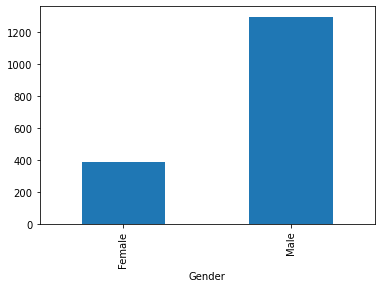

In [16]:
#Plot for gender
df_bio_gender_plot=df_bio_gender.groupby(["Gender"])["Gender"].count()
df_bio_gender_plot.plot.bar(x="Gender", y="count")

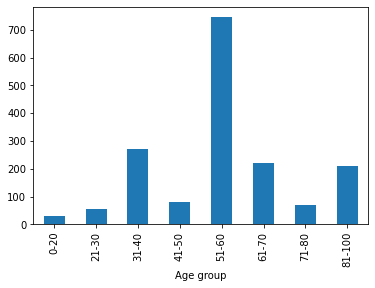

In [17]:
#Plot for age
df_bio_age_plot=df_bio_age.groupby(["Age group"])["Age group"].count()
df_bio_age_plot.plot.bar(x="Age group", y="count")

In [226]:
#Train-Test-Split

#Creating single dataframe with total images path 
image_paths = df1.loc[df1.index.repeat(df1['Count'])]
image_paths['image_path'] = 1 + image_paths.groupby('Name').cumcount()
#image_paths
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.Name + "/" + image_paths.Name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("Count",1)

#Splitting into test and train
img_train, img_test = train_test_split(image_paths, test_size=0.2)
img_train = img_train.reset_index().drop("index",1)
img_test = img_test.reset_index().drop("index",1)
#print(image_paths)
#print(img_test)

#Checking how the data is split between test and train folder
a = len(set(img_train.Name).intersection(set(img_test.Name)))
b = len(set(img_test.Name) - set(img_train.Name))
c = len(set(img_train.Name) - set(img_test.Name))
d = img_train.shape[0]
e = img_test.shape[0]


In [227]:
#Printing the final EDA
print("Observation: There are total of", unique_celeb, "person's data available with a total of", 
      tot_img," images provided out of which ", 
      zero_count, "folder has no image provided and ", 
      single_count, "individuals has just one image provided for training. All image provided are of 250*250 dimension.",
     "The whole dataset has been split to training and test 80-20 basis. Training folder has a total of ",d, 
      "images and test folder has a total of ",e,
      "There are",
      a,"groups of individual who has data in both training and test dataset;", b,
     "groups of individual who can data only in test dataset and ", 
      c, "groups of individual who has data only in training dataset but not in test dataset")

Observation: There are total of 1680 person's data available with a total of 9164  images provided out of which  0 folder has no image provided and  0 individuals has just one image provided for training. All image provided are of 250*250 dimension. The whole dataset has been split to training and test 80-20 basis. Training folder has a total of  7331 images and test folder has a total of  1833 There are 873 groups of individual who has data in both training and test dataset; 33 groups of individual who can data only in test dataset and  774 groups of individual who has data only in training dataset but not in test dataset


In [176]:
#Copying the split data into specific folders for the actual training and testing to start

test_lists = img_test["image_path"].to_list()
train_lists = img_train["image_path"].to_list()

test_celeb_lists = img_test["Name"].to_list()
train_celeb_lists = img_train["Name"].to_list()

test_lists.sort()
train_lists.sort()

for test_celeb_list in test_celeb_lists:
    if path.exists("projectData/P3_Face_verification/pb_testing/test_folder/"+test_celeb_list):
        pass
    else:
        os.makedirs("projectData/P3_Face_verification/pb_testing/test_folder/"+test_celeb_list)

for train_celeb_list in train_celeb_lists:
    if path.exists("projectData/P3_Face_verification/pb_testing/training_folder/"+train_celeb_list):
        pass
    else:
        os.makedirs("projectData/P3_Face_verification/pb_testing/training_folder/"+train_celeb_list)

        
for test_list in test_lists:
    shutil.copyfile("projectData/P3_Face_verification/pb_testing/faces_sample/"+test_list, 
                    "projectData/P3_Face_verification/pb_testing/test_folder/"+test_list)

for train_list in train_lists:
    shutil.copyfile("projectData/P3_Face_verification/pb_testing/faces_sample/"+train_list, 
                    "projectData/P3_Face_verification/pb_testing/training_folder/"+train_list)


In [185]:
#Code for training the images

detect_front_face = dlib.get_frontal_face_detector()
face_shape_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
face_encoder = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")
TOLERANCE = 0.6

#Defining function to get face encoding for sample image
def face_encoding(image_path):
    img = cv2.imread(image_path)
    face_detected = detect_front_face(img,1)
    face_shape = [face_shape_predictor(img, face) for face in face_detected]
    return [np.array(face_encoder.compute_face_descriptor(img,face_pose,1)) for face_pose in face_shape]

#Defining a function for comparing face encoding with sample image
def compare_face_enc(sample_face, given_face):
    return (np.linalg.norm(sample_face - given_face, axis = 1) <= TOLERANCE)

#Defining a function to return the image name with which a match is found
def finding_match(sample_face, name, given_face):
    matches = compare_face_enc(sample_face, given_face)
    count = 0
    for match in matches:
        #print(count, match)
        if match:
            return name[count]
        count = count+1
    return "Image not found"

#projectData/P3_Face_verification/faces/faces/
#Getting the encoding of the available sample images
name_dir = os.listdir("projectData/P3_Face_verification/pb_testing/training_folder/")
#print(name_dir)
face_enc = []
face_name = []

# Loop through each person in the training directory
for name in name_dir:
    folder_paths = os.listdir("projectData/P3_Face_verification/pb_testing/training_folder/" + name)
    #print(folder_paths)
    for folder_path in folder_paths:
        img_paths = "projectData/P3_Face_verification/pb_testing/training_folder/" + name + "/" + folder_path
        #print(img_paths)
        img_face_enc = face_encoding(img_paths)
        if len(img_face_enc) == 1:
            face_name.append(name)
            face_enc.append(face_encoding(img_paths)[0])
        else :
            print("The image " + img_paths + " has more than single face and cannot be used for training. Hence this image will be skipped")
        


The imageprojectData/P3_Face_verification/pb_testing/training_folder/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imageprojectData/P3_Face_verification/pb_testing/training_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0005.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imageprojectData/P3_Face_verification/pb_testing/training_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0007.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imageprojectData/P3_Face_verification/pb_testing/training_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0038.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imageprojectData/P3_Face_verification/pb_testing/training_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0040.jpg has more than single face 

The imageprojectData/P3_Face_verification/pb_testing/training_folder/George_W_Bush/George_W_Bush_0326.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imageprojectData/P3_Face_verification/pb_testing/training_folder/George_W_Bush/George_W_Bush_0339.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imageprojectData/P3_Face_verification/pb_testing/training_folder/George_W_Bush/George_W_Bush_0453.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imageprojectData/P3_Face_verification/pb_testing/training_folder/George_W_Bush/George_W_Bush_0473.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imageprojectData/P3_Face_verification/pb_testing/training_folder/George_W_Bush/George_W_Bush_0474.jpg has more than single face and cannot be used for training. Hence this image will be skipped
The imagep

In [202]:
#Testing data using images in the split test folder

#Matching the our sample images with the set of test images
#test_filename = filter(lambda x: x.endswith(".JPG"),os.listdir('projectData/P3_Face_verification/pb_testing/test_folder/') )
test_filename = os.listdir('projectData/P3_Face_verification/pb_testing/test_folder/') 
test_paths = ['projectData/P3_Face_verification/pb_testing/test_folder/' + x for x in test_filename]

for test_path in test_paths:
    test_img_paths = os.listdir(test_path)
    for test_img_path in test_img_paths:
        test_img_name = test_path + "/" +test_img_path
        test_face_enc = face_encoding(test_img_name)
        if len(test_face_enc) != 1:
            print(test_path+" cannot be used for detection!! Try with another image!!")
        else:
            face_match = finding_match(face_enc, face_name, test_face_enc[0])
            print(test_img_name, face_match)

projectData/P3_Face_verification/pb_testing/test_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0002.jpg Arnold_Schwarzenegger
projectData/P3_Face_verification/pb_testing/test_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0015.jpg Arnold_Schwarzenegger
projectData/P3_Face_verification/pb_testing/test_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0025.jpg Arnold_Schwarzenegger
projectData/P3_Face_verification/pb_testing/test_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0028.jpg Aaron_Sorkin
projectData/P3_Face_verification/pb_testing/test_folder/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0035.jpg Arnold_Schwarzenegger
projectData/P3_Face_verification/pb_testing/test_folder/Bill_Clinton/Bill_Clinton_0005.jpg Bill_Clinton
projectData/P3_Face_verification/pb_testing/test_folder/Bill_Clinton cannot be used for detection!! Try with another image!!
projectData/P3_Face_verification/pb_testing/test_folder/Bill_Clinton/Bill_Clinton_0011.jpg Bill_Clinton
projectData/P3_Face_v

projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0202.jpg Bill_Graham
projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0203.jpg Arnold_Schwarzenegger
projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0204.jpg Arnold_Schwarzenegger
projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0209.jpg Bill_Simon
projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0229.jpg Bill_McBride
projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0240.jpg George_W_Bush
projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0249.jpg Arnold_Schwarzenegger
projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0258.jpg Arnold_Schwarzenegger
projectData/P3_Face_verification/pb_testing/test_folder/George_W_Bush/George_W_Bush_0263.jpg Arnold_Schwarzenegger
pro

In [ ]:
#Checking accuracy